# Cats and dogs

In [26]:
using Pkg; Pkg.activate("..")

  Activating environment at `~/Documents/code/CounterfactualExplanations.jl/dev/Project.toml`


In [48]:
include("generate_artifacts.jl")
data_dir = "../data"
artifact_name = "cats_dogs";

### Generate toy data

In [28]:
using Random
Random.seed!(1234)
averages = (dog=[100;20],cat=[50;50])
D = 2
N = 1000
y = rand([0,1],N)
dog_label = 1
cat_label = 0
X = zeros(D,N)
dogs = findall(y.==dog_label)
cats = findall(y.==cat_label)
noise = 0.1
noise_cats = randn(D,length(cats)) .* noise .*averages.cat 
noise_dogs = randn(D,length(dogs)) .* noise .*averages.dog 
X[:,cats] .= averages.cat .+ noise_cats
X[:,dogs] .= averages.dog .+ noise_dogs;

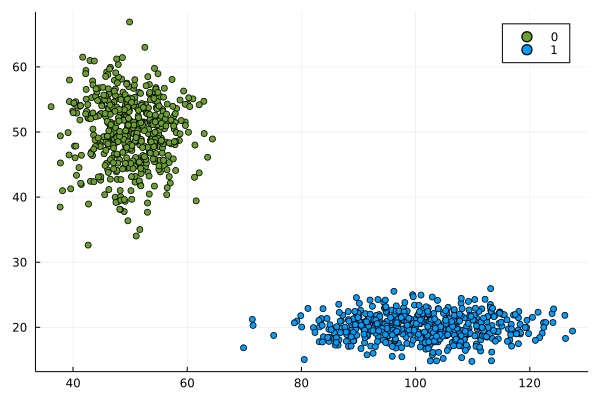

In [29]:
using Plots
scatter(X[1,:],X[2,:],color=Int.(y),group=Int.(y))

In [30]:
data = Dict(
        "X" => X,
        "y" => y
    )
using BSON: @save
datafile = artifact_name * "_data.bson"
@save joinpath(data_dir, datafile) data

### Classifiers

In [31]:
using Flux
X = Flux.normalise(X,dims=2)
x = Flux.unstack(X,2)
data = zip(x,y)
n_hidden = 32
model = Chain(
  Dense(2,n_hidden,σ),
  Dense(n_hidden,1)
)
λ = 0.1
sqnorm(x) = sum(abs2, x)
weight_regularization(λ=λ) = 1/2 * λ^2 * sum(sqnorm, Flux.params(model))
loss(x, y) = Flux.Losses.logitbinarycrossentropy(model(x), y) + weight_regularization()

# Training
using Flux.Optimise: update!, ADAM
using Statistics
opt = ADAM()
epochs = 10

for epoch = 1:epochs
  for d in data
    gs = gradient(params(model)) do
      l = loss(d...)
    end
    update!(opt, params(model), gs)
  end
end

# MLP
modelfile = artifact_name * "_model.bson"
@save joinpath(data_dir, modelfile) model

# Laplace approximation
using BayesLaplace
la = laplace(model, λ=λ, subset_of_weights=:all)
fit!(la, data)
laplacefile = artifact_name * "_laplace.bson"
@save joinpath(data_dir, laplacefile) la

In [32]:
using CounterfactualExplanations, CounterfactualExplanations.Models
import CounterfactualExplanations.Models: logits, probs # import functions in order to extend

# Step 1)
struct NeuralNetwork <: Models.AbstractFittedModel
    model::Any
end

# Step 2)
logits(𝑴::NeuralNetwork, X::AbstractArray) = 𝑴.model(X)
probs(𝑴::NeuralNetwork, X::AbstractArray)= σ.(logits(𝑴, X))
𝑴 = NeuralNetwork(model);

In [33]:
# Step 1)
struct LaplaceNeuralNetwork <: Models.AbstractFittedModel
    la::BayesLaplace.LaplaceRedux
end

# Step 2)
logits(𝑴::LaplaceNeuralNetwork, X::AbstractArray) = 𝑴.la.model(X)
probs(𝑴::LaplaceNeuralNetwork, X::AbstractArray)= BayesLaplace.predict(𝑴.la, X)
𝑴ᴸ = LaplaceNeuralNetwork(la);

### Images

In [34]:
imagefiles = artifact_name * "_images"
image_dir = joinpath(data_dir, imagefiles)
if !isdir(image_dir)
    mkdir(image_dir)
end
cats = findall(y.==0)
dogs = findall(y.==1)
using Images, FileIO
cat = load("../www/cat.png")
dog = load("../www/dog.png")
ms = 50
marker = map(y -> y==0 ? cat : dog,y);

In [35]:
using GLMakie
using GLMakie: scatter!, Axis
f = Figure()
ax = Axis(f[1,1],xlabel="Height",ylabel="Tail length")
scatter!(X[1,cats],X[2,cats],marker=cat,markersize=ms)
scatter!(X[1,dogs],X[2,dogs],marker=dog,markersize=ms)
save(joinpath(image_dir,"samples.png"), f);

In [36]:
using Makie: contourf!
function plot_contour_makie(X,y,𝑴;clegend=true,title="",length_out=50,zoom=-0.1,xlim=nothing,ylim=nothing,linewidth=0.1,xlab="",ylab="")
    
    # Surface range:
    if isnothing(xlim)
        xlim = (minimum(X[:,1]),maximum(X[:,1])).+(zoom,-zoom)
    else
        xlim = xlim .+ (zoom,-zoom)
    end
    if isnothing(ylim)
        ylim = (minimum(X[:,2]),maximum(X[:,2])).+(zoom,-zoom)
    else
        ylim = ylim .+ (zoom,-zoom)
    end
    x_range = collect(range(xlim[1],stop=xlim[2],length=length_out))
    y_range = collect(range(ylim[1],stop=ylim[2],length=length_out))
    Z = [Models.probs(𝑴,[x, y])[1] for x=x_range, y=y_range]

    f = Figure()
    ax = Axis(f[1, 1], title=title, xlabel=xlab, ylabel=ylab)
    hidedecorations!(ax, label=false)  # hides ticks, grid and lables
    hidespines!(ax)  # hide the frame

    # Plot:
    co = contourf!(
        x_range, y_range, Z; 
        colorbar=clegend, linewidth=linewidth,
        xlim=xlim,
        ylim=ylim,
        levels = 0.0:0.05:1.0,
        extendlow = :auto, extendhigh = :auto
    )

    Colorbar(f[1,2],co)
    
    scatter!(X'[1,cats],X'[2,cats],marker=cat,markersize=ms)
    scatter!(X'[1,dogs],X'[2,dogs],marker=dog,markersize=ms)

    return f
end;

In [37]:
f = plot_contour_makie(X',y,𝑴,title="MLP",xlab="Height",ylab="Tail length")
save(joinpath(image_dir,"predictive_mlp.png"), f)
fᴸ = plot_contour_makie(X',y,𝑴ᴸ,title="Laplace",xlab="Height",ylab="Tail length")
save(joinpath(image_dir,"predictive_laplace.png"), fᴸ)

GLMakie.Screen(...)

#### Counterfactuals


In [38]:
using Random
Random.seed!(1234)
cats = findall(y.==0)
x̅ = X[:,rand(cats)]
y̅ = 0.0
target = 1.0 # opposite label as target
γ = 0.75; # desired level of confidence

In [39]:
generator = GenericGenerator(0.1,0.05,1e-5,:logitbinarycrossentropy,nothing)
recourse = generate_counterfactual(generator, x̅, 𝑴, target, γ); # generate recourse

In [40]:
T = size(recourse.path)[1]
X_path = reduce(hcat,recourse.path)
ŷ = CounterfactualExplanations.target_probs(probs(recourse.𝑴, X_path),target)
plt = plot_contour_makie(X',y,𝑴,xlab="Height",ylab="Tail length")
for t in 1:T
    scatter!([recourse.path[t][1]], [recourse.path[t][2]],marker=cat,markersize=ms)    
end
save(joinpath(image_dir,"recourse_mlp.png"),plt);

In [41]:
fig = plot_contour_makie(X',y,𝑴,xlab="Height",ylab="Tail length")
# animation settings
timestamps = range(1, T, step=1)
record(fig, joinpath(image_dir,"recourse_mlp.gif"), timestamps; framerate = 10) do t
    scatter!([recourse.path[Int(t)][1]], [recourse.path[Int(t)][2]],marker=cat,markersize=ms)
end;

### ... towards realistic counterfactuals.

In [42]:
generator = GreedyGenerator(0.1,20,:logitbinarycrossentropy,nothing)
recourse = generate_counterfactual(generator, x̅, 𝑴ᴸ, target, γ); # generate recourse

In [43]:
T = size(recourse.path)[1]
X_path = reduce(hcat,recourse.path)
ŷ = CounterfactualExplanations.target_probs(probs(recourse.𝑴, X_path),target)
plt = plot_contour_makie(X',y,𝑴ᴸ,xlab="Height",ylab="Tail length")
for t in 1:T
    scatter!([recourse.path[t][1]], [recourse.path[t][2]],marker=cat,markersize=ms)    
end
save(joinpath(image_dir,"recourse_laplace.png"),plt);

In [44]:
fig = plot_contour_makie(X',y,𝑴ᴸ,xlab="Height",ylab="Tail length")
# animation settings
timestamps = range(1, T, step=1)
record(fig, joinpath(image_dir,"recourse_laplace.gif"), timestamps; framerate = 10) do t
    scatter!([recourse.path[Int(t)][1]], [recourse.path[Int(t)][2]],marker=cat,markersize=ms)
end;

### Generate artifacts

In [49]:
datafiles = [datafile, modelfile, laplacefile, imagefiles]
generate_artifact(datafiles)

┌ Warning: For automatic github deployment, need GITHUB_TOKEN. Not found in ENV, attemptimg global git config.
└ @ Main /Users/FA31DU/Documents/code/CounterfactualExplanations.jl/dev/artifacts/generate_artifacts.jl:13
┌ Info: Binding cats_dogs_data in Artifacts.toml...
└ @ Main /Users/FA31DU/Documents/code/CounterfactualExplanations.jl/dev/artifacts/generate_artifacts.jl:53


┌ Info: Binding cats_dogs_model in Artifacts.toml...
└ @ Main /Users/FA31DU/Documents/code/CounterfactualExplanations.jl/dev/artifacts/generate_artifacts.jl:53


┌ Info: Binding cats_dogs_laplace in Artifacts.toml...
└ @ Main /Users/FA31DU/Documents/code/CounterfactualExplanations.jl/dev/artifacts/generate_artifacts.jl:53


┌ Info: Binding cats_dogs_images in Artifacts.toml...
└ @ Main /Users/FA31DU/Documents/code/CounterfactualExplanations.jl/dev/artifacts/generate_artifacts.jl:53
┌ Info: Uploading tarballs to pat-alt/CounterfactualExplanations.jl tag `data`
└ @ Main /Users/FA31DU/Documents/code/CounterfactualExplanations.jl/dev/artifacts/generate_artifacts.jl:64


--> Deleting: cats_dogs_model.tar.gz
--> Deleting: cats_dogs_laplace.tar.gz
--> Deleting: cats_dogs_data.tar.gz
--> Deleting: cats_dogs_images.tar.gz
--> Uploading: cats_dogs_data.tar.gz
--> Uploading: cats_dogs_model.tar.gz
--> Uploading: cats_dogs_images.tar.gz
--> Uploading: cats_dogs_laplace.tar.gz


┌ Info: Artifacts.toml file now contains all bound artifact names
└ @ Main /Users/FA31DU/Documents/code/CounterfactualExplanations.jl/dev/artifacts/generate_artifacts.jl:70
